## Data reading and Data Insights

**Creating literary works (using imagination to write poems, stories, plays, and various creative writings): apnonb4q, 32 days participation**

*Dataset:*  Creating literary works (using imagination to write poems, stories, plays, and various creative writings) vs Not creating literary works

#### Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.scan import scan

In [24]:
path = "C://Users//USER//Desktop//StudyU_Results//"
df_intervention = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_creating_literary_works_-_apnonb4q_2025-05-19 20_23_39.160//interventions.csv")
#print(df_intervention.head())
df_mea = pd.read_csv(path+"self-designed_n-of-1_trials_on_stress_management_-_creating_literary_works_-_apnonb4q_2025-05-19 20_23_39.160//measurements.csv")
#print(df_mea.head())

## Data Analysis and Preprocessing

- Pre-analysis: apnonb4q
    - Number of Participant
    - Participation of the study
    - Missing Values
    - Remove Participants Who Joined Outside the Study
    - Data Preperation

#### Number of Participant

In [25]:
column_name = 'participant_id' 

unique_count = df_intervention[column_name].nunique()

if unique_count == 1:
    only_value = df_intervention[column_name].iloc[0]
    print(f"The column '{column_name}' has only one unique value: {only_value!r}")
else:
    print(f"The column '{column_name}' has {unique_count} unique values.")
    print("Unique values are:", df_intervention[column_name].unique())

The column 'participant_id' has 2 unique values.
Unique values are: ['a11d06dc-8a5c-4f21-94f9-e61e76681084'
 'ae098342-296b-4dca-83c0-76b2f3507008']


#### Participation of the study

In [26]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'], utc=True)

participation_days = (
    df_mea
    .groupby('participant_id')['measurement_time']
    .apply(lambda x: x.dt.date.nunique())
    .reset_index(name='participation_days')
)

print(participation_days)

                         participant_id  participation_days
0  a11d06dc-8a5c-4f21-94f9-e61e76681084                  28


During the 32-day study period, there were 4 days without any participation.

#### Missing Values

In [27]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in ['Outcome', 'Mediators']:
        sub = df_part[df_part['measurement_name'] == name].copy()
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),          
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a11d06dc-8a5c-4f21-94f9-e61e76681084 ---

  Outcome:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-04-19
       2025-04-21
       2025-05-10
       2025-05-17

  Mediators:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-04-19
       2025-04-21
       2025-05-10
       2025-05-17


#### Remove Participants Who Joined Outside the Study

In [28]:
df_mea = df_mea[df_mea['participant_id'] != 'ae098342-296b-4dca-83c0-76b2f3507008']
df_mea.shape[0]

56

#### Data Preperation

In [29]:
df_mea_all= df_mea[[
     'measurement_time',
     'measurement_name',
     'participant_id',
     'current_day_of_study',
     'current_intervention_name',
     'survey1_question1_response',
     'survey1_question2_response',
     'survey1_question3_response',
     'survey1_question4_response',
     'survey2_question1_response',
     'survey2_question2_response']]
df_mea_all.head(1)

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
0,2025-05-18 19:02:16.925347+00:00,Mediators,a11d06dc-8a5c-4f21-94f9-e61e76681084,31,Not Creating Literary Works!,NaN,NaN,NaN,NaN,6.0,6.0


In [30]:
df_mea_m = df_mea_all[df_mea_all['measurement_name'] == 'Mediators']
df_mea_o = df_mea_all[df_mea_all['measurement_name'] == 'Outcome']

In [31]:
df_mea_o = df_mea_o.sort_values(by=['participant_id', 'current_day_of_study'])
df_mea_m = df_mea_m.sort_values(by=['participant_id', 'current_day_of_study'])

In [32]:
df_mea_o.head()

,measurement_time,measurement_name,participant_id,current_day_of_study,current_intervention_name,survey1_question1_response,survey1_question2_response,survey1_question3_response,survey1_question4_response,survey2_question1_response,survey2_question2_response
55,2025-04-17 19:32:15.106956+00:00,Outcome,a11d06dc-8a5c-4f21-94f9-e61e76681084,0,Creating Literary Works!,3.0,2.0,5.0,1.0,NaN,NaN
53,2025-04-18 20:45:26.083541+00:00,Outcome,a11d06dc-8a5c-4f21-94f9-e61e76681084,1,Creating Literary Works!,2.0,3.0,7.0,1.0,NaN,NaN
51,2025-04-20 21:36:52.323678+00:00,Outcome,a11d06dc-8a5c-4f21-94f9-e61e76681084,3,Creating Literary Works!,4.0,3.0,6.0,1.0,NaN,NaN
48,2025-04-22 19:08:14.192779+00:00,Outcome,a11d06dc-8a5c-4f21-94f9-e61e76681084,5,Not Creating Literary Works!,3.0,8.0,1.0,6.0,NaN,NaN
46,2025-04-23 19:36:02.305295+00:00,Outcome,a11d06dc-8a5c-4f21-94f9-e61e76681084,6,Not Creating Literary Works!,5.0,8.0,1.0,6.0,NaN,NaN


## Exploratory Data Analysis - Outcome

- EDA Steps  
  - Data shape  
  - Data types of columns  
  - Missing values  
  - Summary statistics  
  - Data Visualization and Distributions  
    - Plot histograms and box plots  
    - Line plot  
    - Scatter plot  
    - Correlations (Pearson, Kendall, Spearman)    

#### Data Shape

In [33]:
print("Outcome Data Shape")
print("Rows:", df_mea_o.shape[0])
print("Columns:", df_mea_o.shape[1])

Outcome Data Shape
Rows: 28
Columns: 11


#### Data Types of columns

In [34]:
print("Outcome Data Types of Columns")
data_types = df_mea_o.dtypes
data_types_df = pd.DataFrame(data_types, columns=["Data Type"])
print(data_types_df)

Outcome Data Types of Columns
                                      Data Type
measurement_time            datetime64[ns, UTC]
measurement_name                         object
participant_id                           object
current_day_of_study                      int64
current_intervention_name                object
survey1_question1_response              float64
survey1_question2_response              float64
survey1_question3_response              float64
survey1_question4_response              float64
survey2_question1_response              float64
survey2_question2_response              float64


#### Missing Value Analysis

In [35]:
df_mea['measurement_time'] = pd.to_datetime(df_mea['measurement_time'])

df_mea.columns = df_mea.columns.str.strip()
df_mea['measurement_name'] = df_mea['measurement_name'].str.strip()

measurement_names = [
    'Outcome',
    'Mediators',
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response',
    'survey2_question1_response',
    'survey2_question2_response'
]

results = {}

for pid in df_mea['participant_id'].unique():
    results[pid] = {}
    df_part = df_mea[df_mea['participant_id'] == pid]
    
    for name in measurement_names:
        if name in ['Outcome', 'Mediators']:
            sub = df_part[df_part['measurement_name'] == name].copy()
        else:
            if name not in df_part.columns:
                sub = pd.DataFrame()
            else:
                sub = df_part[df_part[name].notna()].copy()
        
        if sub.empty:
            results[pid][name] = None
            continue

        sub['date'] = sub['measurement_time'].dt.date

        start_date = sub['date'].min()

        expected_dates = pd.date_range(start_date, periods=32, freq='D').date

        done_dates = set(sub['date']) & set(expected_dates)

        missed_dates = sorted(set(expected_dates) - done_dates)

        results[pid][name] = {
            'start_date': start_date,
            'end_expected': expected_dates[-1],
            'expected_days': len(expected_dates),      
            'completed_days': len(done_dates),
            'missed_days_count': len(missed_dates),
            'missed_dates': missed_dates
        }

for pid, measures in results.items():
    print(f"\n--- Participant {pid} ---")
    for name, stats in measures.items():
        if stats is None:
            print(f"{name}: no data")
            continue
        print(f"\n  {name}:")
        print(f"    Start date:           {stats['start_date']}")
        print(f"    End of expected 16d:  {stats['end_expected']}")
        print(f"    Expected days count:  {stats['expected_days']}")
        print(f"    Completed days count: {stats['completed_days']}")
        print(f"    Missed days count:    {stats['missed_days_count']}")
        if stats['missed_dates']:
            print("    Missed dates:")
            for d in stats['missed_dates']:
                print("      ", d)


--- Participant a11d06dc-8a5c-4f21-94f9-e61e76681084 ---

  Outcome:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-04-19
       2025-04-21
       2025-05-10
       2025-05-17

  Mediators:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-04-19
       2025-04-21
       2025-05-10
       2025-05-17

  survey1_question1_response:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
    Completed days count: 28
    Missed days count:    4
    Missed dates:
       2025-04-19
       2025-04-21
       2025-05-10
       2025-05-17

  survey1_question2_response:
    Start date:           2025-04-17
    End of expected 16d:  2025-05-18
    Expected days count:  32
 

#### Missing Values for Confirmations between 08.00 - 21.00

In [36]:
df_intervention['intervention_task_time'] = pd.to_datetime(
    df_intervention['intervention_task_time'],
    errors='coerce'
)

df_intervention['date'] = df_intervention['intervention_task_time'].dt.date

start_date = df_intervention['date'].min()
full_range = pd.date_range(start=start_date, periods=32, freq='D').date

full_df = pd.DataFrame({'date': full_range})
merged = full_df.merge(
    df_intervention[['date', 'intervention_task_name']],
    on='date',
    how='left'
)

missing_days = merged[merged['intervention_task_name'].isna()]

if missing_days.empty:
    print("All 32 days have participation confirmations; no missing days found.")
else:
    print("Missing participation days and their corresponding task names:")
    print(missing_days)

Missing participation days and their corresponding task names:
          date intervention_task_name
18  2025-05-04                    NaN
20  2025-05-06                    NaN
25  2025-05-11                    NaN
31  2025-05-17                    NaN


#### Summary Statistics

In [37]:
print("Sleep Data Summary Statistics")
summary_stats = df_mea_o.describe()
print(summary_stats)

Sleep Data Summary Statistics
       current_day_of_study  survey1_question1_response  \
count             28.000000                   28.000000   
mean              15.607143                    4.428571   
std                8.916648                    1.772811   
min                0.000000                    2.000000   
25%                8.750000                    3.000000   
50%               15.500000                    4.500000   
75%               22.500000                    6.000000   
max               31.000000                    8.000000   

       survey1_question2_response  survey1_question3_response  \
count                   28.000000                   28.000000   
mean                     5.392857                    4.107143   
std                      2.346618                    3.107211   
min                      2.000000                    1.000000   
25%                      3.000000                    1.000000   
50%                      5.000000               

In [38]:
df_mea_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 55 to 1
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   measurement_time            28 non-null     datetime64[ns, UTC]
 1   measurement_name            28 non-null     object             
 2   participant_id              28 non-null     object             
 3   current_day_of_study        28 non-null     int64              
 4   current_intervention_name   28 non-null     object             
 5   survey1_question1_response  28 non-null     float64            
 6   survey1_question2_response  28 non-null     float64            
 7   survey1_question3_response  28 non-null     float64            
 8   survey1_question4_response  28 non-null     float64            
 9   survey2_question1_response  0 non-null      float64            
 10  survey2_question2_response  0 non-null      float64            
dtype

#### Data Visualization and Distributions

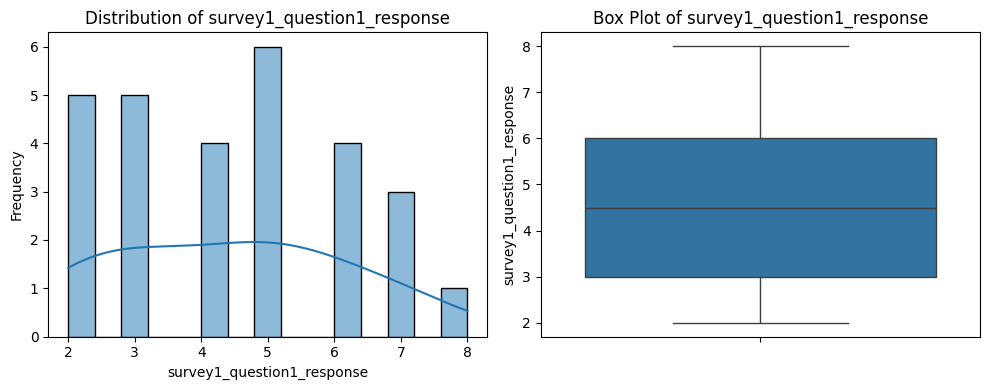

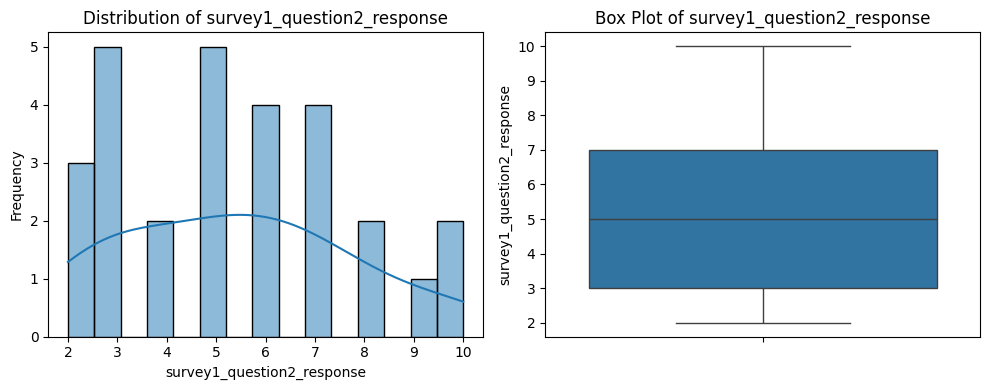

In [39]:
columns = [
    'survey1_question1_response',
    'survey1_question2_response']
for column in columns:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_mea_o[column].dropna(), bins=15, kde=True)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_mea_o[column].dropna())
    plt.title(f"Box Plot of {column}")
    plt.ylabel(column)

    plt.tight_layout()
    plt.show()

#### Line Plot

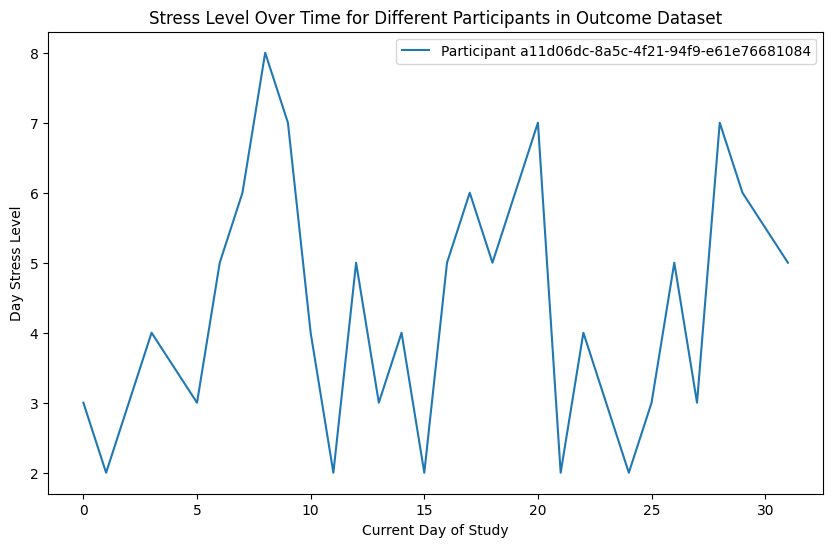

In [40]:
grouped_data = df_mea_o.groupby("participant_id")

plt.figure(figsize=(10, 6)) 

for participant_id, group in grouped_data:
    plt.plot(group['current_day_of_study'], group['survey1_question1_response'], label=f'Participant {participant_id}')

plt.xlabel('Current Day of Study')
plt.ylabel('Day Stress Level')
plt.title('Stress Level Over Time for Different Participants in Outcome Dataset')

plt.legend()
plt.show()


#### Scatterplot

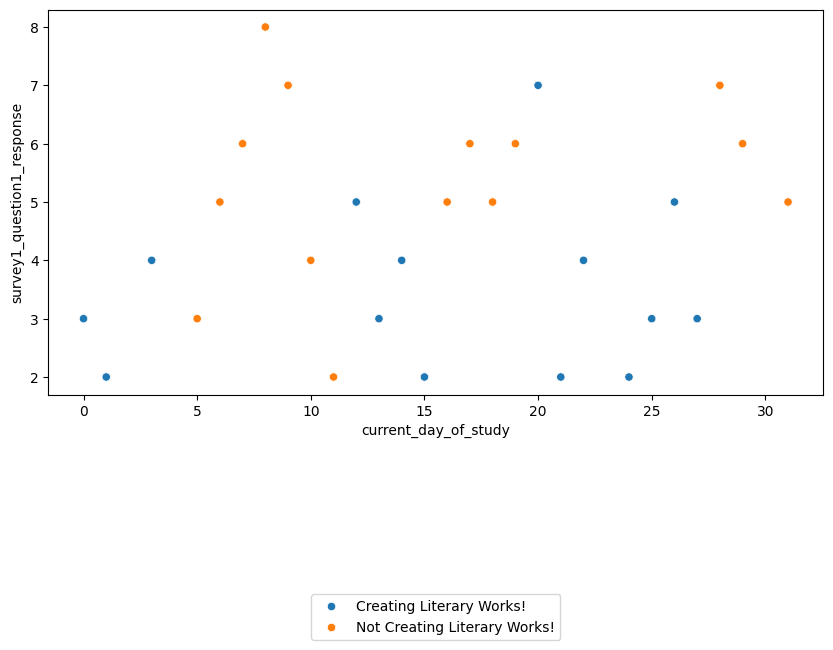

In [41]:
x = 'current_day_of_study'
y = 'survey1_question1_response'

participant_list= list(df_mea_o.participant_id.unique())
fig, axs = plt.subplots(len(participant_list), figsize=(10, 5 * len(participant_list)))

if len(participant_list) == 1:
    axs = [axs]

for i in range(len(participant_list)):
    legend = True if i == len(participant_list)-1 else False
    sns.scatterplot(
        data=df_mea_o[df_mea_o["participant_id"] == participant_list[i]],
        x=x, y=y, hue='current_intervention_name',
        ax=axs[i], legend=legend
    )

axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5))

#### Correlations

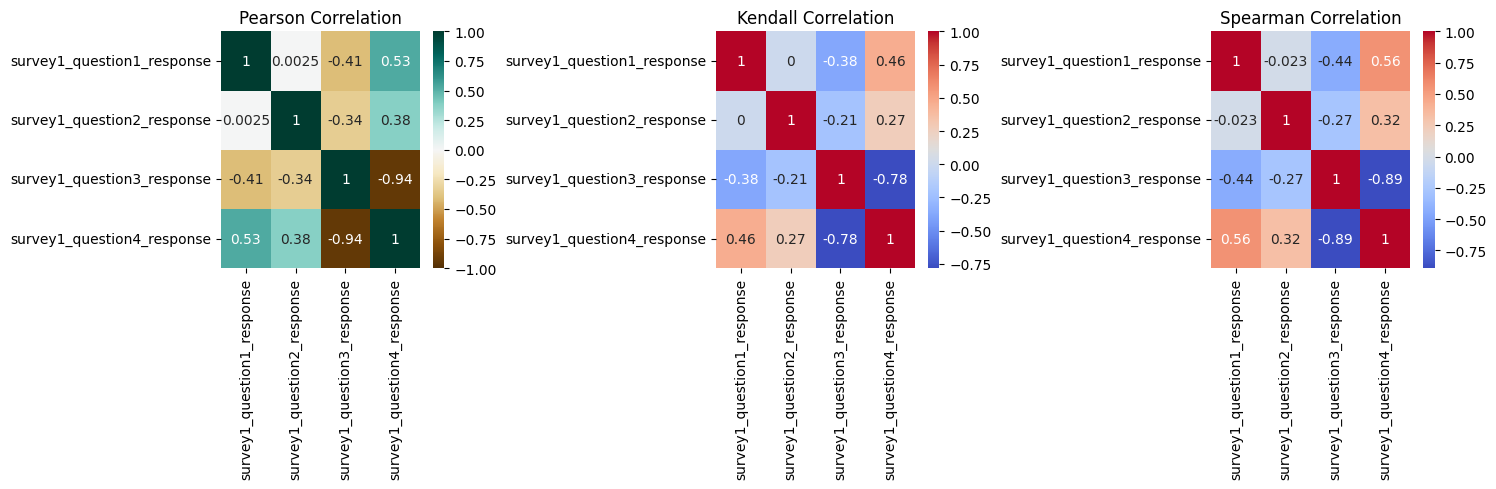

In [42]:
columns_to_include = [
    'survey1_question1_response',
    'survey1_question2_response',
    'survey1_question3_response',
    'survey1_question4_response']

correlation_pearson = df_mea_all[columns_to_include].corr(method='pearson')
correlation_kendall = df_mea_all[columns_to_include].corr(method='kendall')
correlation_spearman = df_mea_all[columns_to_include].corr(method='spearman')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(correlation_pearson, vmin=-1, vmax=1, annot=True, cmap='BrBG',ax=axes[0], center=0)
axes[0].set_title('Pearson Correlation')

sns.heatmap(correlation_kendall, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title('Kendall Correlation')

sns.heatmap(correlation_spearman, annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title('Spearman Correlation')

plt.tight_layout()
plt.show()

## Baseline Study: Intervention - Listening to Music vs Not Listening to Music

  - Baseline Studies  
    - Examination of Outcomes   
    - Linear Regression  
      - Ordinary Least Squares (OLS) Regression  
      - Linear Regression with Autoregressive Errors 
      - Bayesian linear regression models
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators
        - Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)
        - Bayesian AR(1) Regression with Consecutive‐Day Adjustment
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Mean Imputation Method
        - Bayesian AR(1) Model of Daily Stress Response to Intervention and Mediators - Latent Variable Method

#### Examination of Outcomes: Today Stress Level

In [43]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Creating Literary Works!",
        "Not Creating Literary Works!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question1_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question1_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")

Concretizing good things:           n = 14, std = 1.45, mean = 3.50
Not concretizing good things:       n = 14, std = 1.60, mean = 5.36



#### Examination of Outcomes: Prediction of Tomorrow Stress

In [44]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question2_response'].notna() &
    df_mea_o['current_intervention_name'].isin([
        "Creating Literary Works!",
        "Not Creating Literary Works!"
    ])
]

concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question2_response'
]
avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question2_response'
]

n_concretizing         = concretizing.count()
n_avoid_concretizing   = avoid_concretizing.count()
std_concretizing       = concretizing.std(ddof=1)
std_avoid_concretizing = avoid_concretizing.std(ddof=1)

print(f"Concretizing good things:           n = {n_concretizing}, std = {std_concretizing:.2f}, mean = {concretizing.mean():.2f}")
print(f"Not concretizing good things:       n = {n_avoid_concretizing}, std = {std_avoid_concretizing:.2f}, mean = {avoid_concretizing.mean():.2f}\n")


Concretizing good things:           n = 14, std = 1.86, mean = 4.71
Not concretizing good things:       n = 14, std = 2.64, mean = 6.07



#### Examination of Outcomes: Mean Stress-Relief Score for Creating Literary Works (Q3)
The average score for Question 3 (survey1_question3_response), which assesses how much  to concretizing good things alleviated participants’ stress on days they performed.

In [45]:
df_mea.survey1_question3_text[0]

"Did your miracle stress-shrinking method (creative writing) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes? <b> (1 = Not helpful at all to 10 = I'm practically levitating with calmness) <i>(Answer ONLY if you have written creative writing!)</i></b>"

In [46]:
# "Did your miracle stress-shrinking method (creative writing) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes? <b> (1 = Not helpful at all to 10 = I'm practically levitating with calmness) (Answer ONLY if you have written creative writing!)"
mean_q3_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Creating Literary Works!",
    'survey1_question3_response'
].mean()
mean_q3_concretizing.item()


7.0

**Mean Self-Improvement Score for Creating Literary Works (Q3): 7:**
On days when the participant engaged in creative writing, he rated Question 3—“Did your miracle stress-shrinking method (creative writing) help you feel like a calm, happy puppy, or was it more like trying to train a cat to do your taxes?”—an average of **7 out of 10**, indicating that creative writing provided a substantial benefit.


#### Examination of Outcomes: Mean Stress-Management Difficulty Without Creating Literary Works (Q4)
The average score for Question 4 (survey1_question4_response), which measures participants’ difficulty in managing stress on days they did not creative writings.

In [47]:
df_mea.survey1_question4_text[0]

"When you skipped the method (without creative writing) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b> (1 = Easy breezy to 10 = Send help, I'm barely holding it together!) <i>(Answer ONLY if you have NOT written creative writing!)</i></b>"

In [48]:
# "When you skipped the method (without creative writing) today, did managing stress feel more like “breezing through a sunny park” or “juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles”? <b> (1 = Easy breezy to 10 = Send help, I'm barely holding it together!) <i>(Answer ONLY if you have NOT written creative writing!)</i></b>"
mean_q4_avoid_concretizing = df_mea_o.loc[
    df_mea_o['current_intervention_name'] == "Not Creating Literary Works!",
    'survey1_question4_response'
].mean()
mean_q4_avoid_concretizing.item()

6.5

**Mean Stress-Management Difficulty Score Without Creating Literary Works (Q4): 6.5:**
On days when the participant did not engage in creative writing, he rated Question 4—“When you skipped the method (without creative writing) today, did managing stress feel more like ‘breezing through a sunny park’ or ‘juggling flaming torches while riding a unicycle on a tightrope over a pit of snapping crocodiles’?”—an average of **6.5 out of 10**, indicating that going without creative writing posed a moderate challenge in managing stress.

### Estimating treatment effect using Linear Regression with Autoregressive errors

In [49]:
df_mea_o = df_mea_o[
    (df_mea_o['measurement_name'] == 'Outcome') &
    df_mea_o['survey1_question1_response'].notna() &
    df_mea_o['current_intervention_name'].isin(["Creating Literary Works!", "Not Creating Literary Works!"])
]

df_mea_o = df_mea_o.sort_values('measurement_time')

y = df_mea_o['survey1_question1_response']
df_mea_o['D'] = (df_mea_o['current_intervention_name'] == "Creating Literary Works!").astype(int)
X = sm.add_constant(df_mea_o['D'])

ols_res = sm.OLS(y, X).fit()
dw_ols = durbin_watson(ols_res.resid)

print("OLS Regression Results:")
print(ols_res.summary())
print(f"Durbin–Watson statistic (OLS residuals): {dw_ols:.3f}\n")

OLS Regression Results:
                                OLS Regression Results                                
Dep. Variable:     survey1_question1_response   R-squared:                       0.285
Model:                                    OLS   Adj. R-squared:                  0.257
Method:                         Least Squares   F-statistic:                     10.34
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):            0.00347
Time:                                00:47:56   Log-Likelihood:                -50.566
No. Observations:                          28   AIC:                             105.1
Df Residuals:                              26   BIC:                             107.8
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [50]:
glsar = sm.GLSAR(y, X, rho=1)
glsar_res = glsar.iterative_fit(maxiter=10)
dw_glsar = durbin_watson(glsar_res.resid)

print("GLSAR Regression Results (AR(1) error structure):")
print(glsar_res.summary())
print(f"Estimated AR(1) coefficient (rho): {glsar.rho[0]:.3f}")
print(f"Durbin–Watson statistic (GLSAR residuals): {dw_glsar:.3f}")

GLSAR Regression Results (AR(1) error structure):
                               GLSAR Regression Results                               
Dep. Variable:     survey1_question1_response   R-squared:                       0.309
Model:                                  GLSAR   Adj. R-squared:                  0.282
Method:                         Least Squares   F-statistic:                     11.20
Date:                        Thu, 14 Aug 2025   Prob (F-statistic):            0.00258
Time:                                00:47:56   Log-Likelihood:                -49.120
No. Observations:                          27   AIC:                             102.2
Df Residuals:                              25   BIC:                             104.8
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-

#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 199 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.284  0.633    -2.359      0.047      0.027    0.022     543.0   
rho       0.074  0.222    -0.337      0.527      0.010    0.006     549.0   
sigma     1.567  0.219     1.135      1.971      0.009    0.008     578.0   

          ess_tail  r_hat  
beta_int     484.0    1.0  
rho          640.0    1.0  
sigma        684.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 88.80%
P(beta_int ≤ –0.5) = 88.80%
P(–0.5 < beta_int < 0) = 8.10%
P(beta_int ≥ 0) = 3.10%


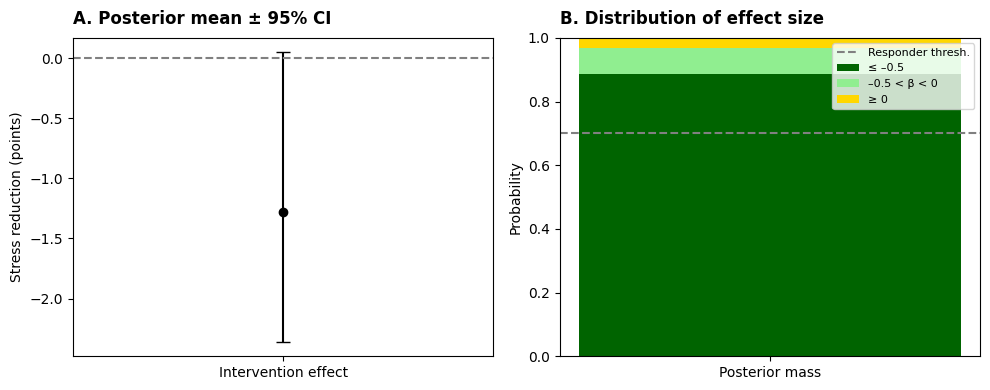

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 418 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.143  0.558    -2.106      0.032      0.023    0.017     632.0   
rho       0.230  0.239    -0.244      0.695      0.011    0.008     490.0   
sigma     1.417  0.203     1.090      1.857      0.008    0.008     586.0   
beta_f1   0.401  0.143     0.138      0.685      0.005    0.004     699.0   

          ess_tail  r_hat  
beta_int     672.0    1.0  
rho          474.0    1.0  
sigma        630.0    1.0  
beta_f1      736.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 87.10%
P(beta_int ≤ –0.5) = 87.10%
P(–0.5 < beta_int < 0) = 10.20%
P(beta_int ≥ 0) = 2.70%


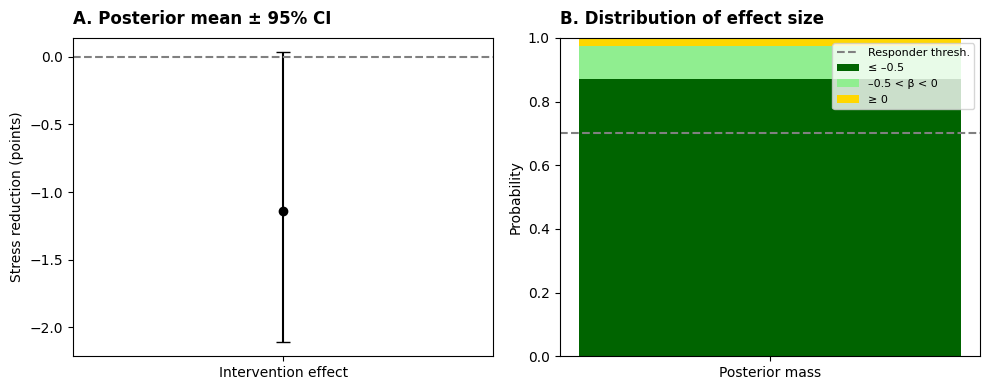

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 430 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.118  0.598    -2.337     -0.035      0.026    0.020     551.0   
rho       0.069  0.232    -0.375      0.550      0.011    0.008     489.0   
sigma     1.573  0.217     1.156      1.964      0.010    0.007     477.0   
beta_f2   0.239  0.205    -0.170      0.632      0.010    0.007     390.0   

          ess_tail  r_hat  
beta_int     586.0   1.00  
rho          398.0   1.00  
sigma        438.0   1.00  
beta_f2      546.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 85.40%
P(beta_int ≤ –0.5) = 85.40%
P(–0.5 < beta_int < 0) = 10.90%
P(beta_int ≥ 0) = 3.70%


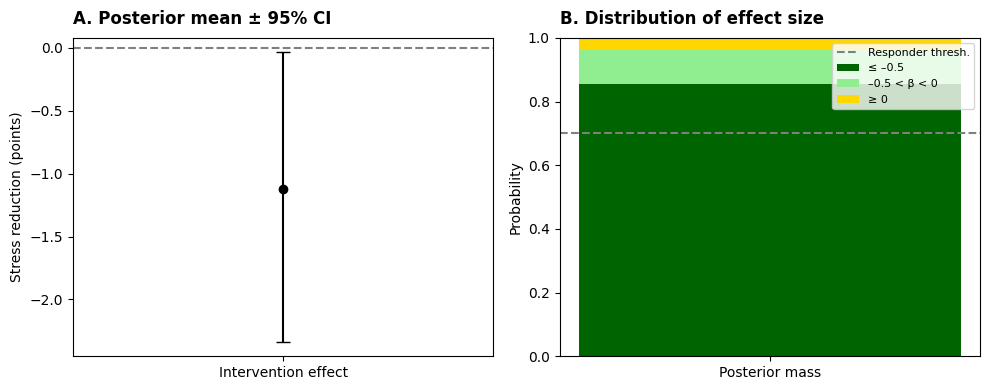

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 461 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.058  0.601    -2.152      0.193      0.024    0.018     650.0   
rho       0.232  0.241    -0.233      0.721      0.010    0.008     627.0   
sigma     1.452  0.215     1.069      1.872      0.008    0.008     713.0   
beta_f1   0.388  0.141     0.125      0.669      0.008    0.004     341.0   
beta_f2   0.126  0.194    -0.234      0.535      0.009    0.007     491.0   

          ess_tail  r_hat  
beta_int     725.0   1.00  
rho          591.0   1.00  
sigma        737.0   1.00  
beta_f1      537.0   1.01  
beta_f2      473.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 81.80%
P(beta_int ≤ –0.5) = 81.80%
P(–0.5 < beta_int < 0) = 13.50%
P(beta_int ≥ 0) = 4.70%


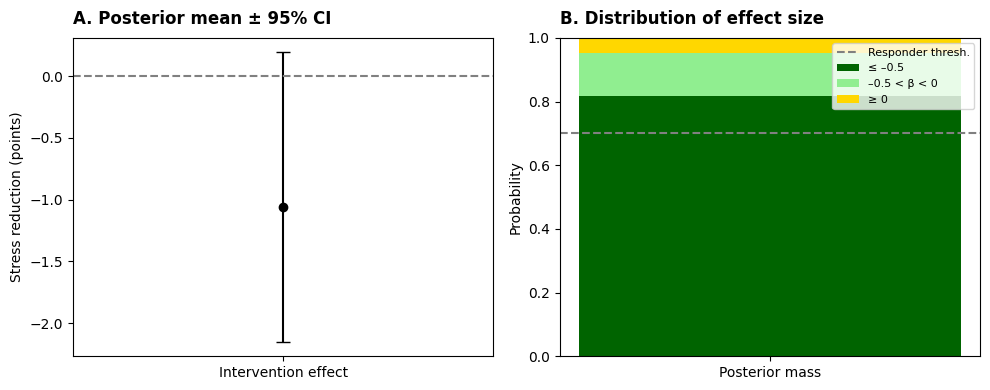

In [51]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Data-Driven Scale (MAD-Based)

Model: Only intervention


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 230 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.385  0.749    -2.770      0.171      0.040    0.040     399.0   
rho       0.089  0.251    -0.378      0.601      0.015    0.013     326.0   
sigma     1.633  0.247     1.232      2.154      0.013    0.011     382.0   

          ess_tail  r_hat  
beta_int     241.0    1.0  
rho          243.0    1.0  
sigma        439.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 88.40%
P(beta_int ≤ –0.5) = 88.40%
P(–0.5 < beta_int < 0) = 7.60%
P(beta_int ≥ 0) = 4.00%


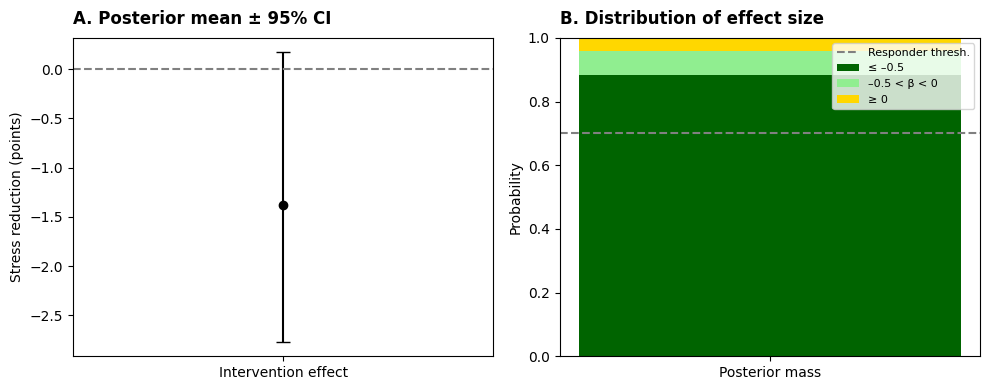


Model: Intervention + fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 379 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.311  0.663    -2.671     -0.122      0.026    0.019     680.0   
rho       0.234  0.247    -0.246      0.715      0.012    0.008     444.0   
sigma     1.473  0.215     1.075      1.877      0.009    0.009     511.0   
beta_f1   0.442  0.153     0.136      0.718      0.007    0.006     443.0   

          ess_tail  r_hat  
beta_int     719.0   1.00  
rho          504.0   1.00  
sigma        725.0   1.00  
beta_f1      496.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 87.80%
P(beta_int ≤ –0.5) = 87.80%
P(–0.5 < beta_int < 0) = 8.80%
P(beta_int ≥ 0) = 3.40%


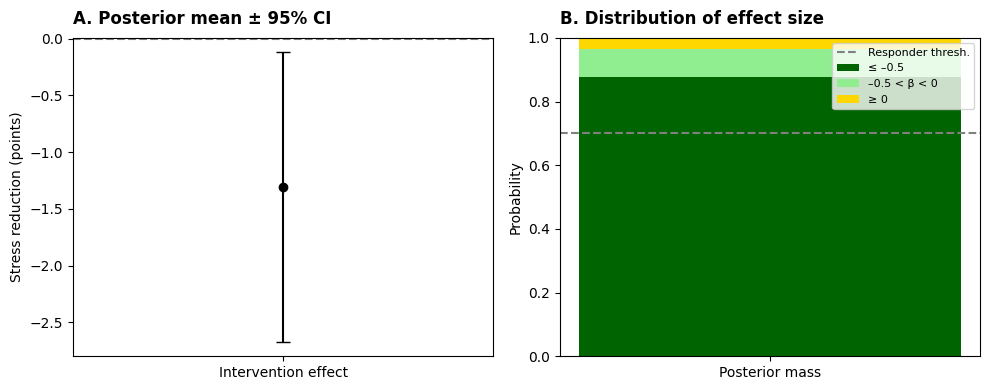


Model: Intervention + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 422 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.251  0.683    -2.471      0.018      0.032    0.029     501.0   
rho       0.053  0.225    -0.351      0.519      0.010    0.008     485.0   
sigma     1.646  0.267     1.188      2.169      0.013    0.013     495.0   
beta_f2   0.311  0.223    -0.147      0.724      0.011    0.010     451.0   

          ess_tail  r_hat  
beta_int     383.0   1.00  
rho          441.0   1.00  
sigma        440.0   1.01  
beta_f2      414.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 85.60%
P(beta_int ≤ –0.5) = 85.60%
P(–0.5 < beta_int < 0) = 11.10%
P(beta_int ≥ 0) = 3.30%


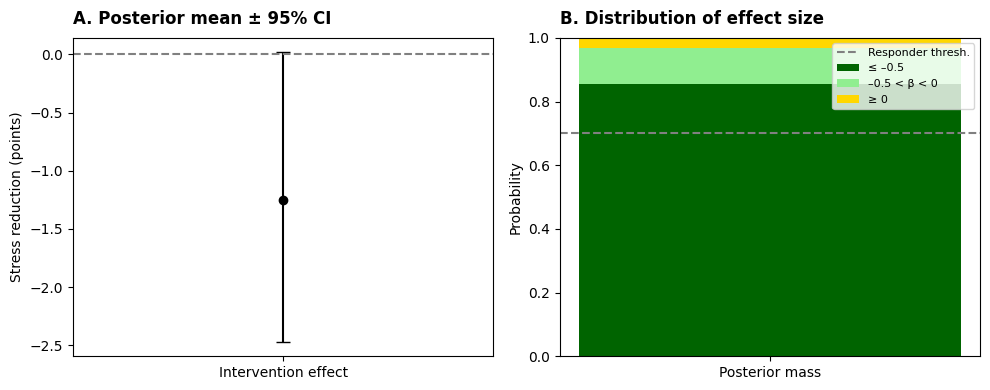


Model: Intervention + fac1 + fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 518 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.231  0.684    -2.588      0.155      0.032    0.025     482.0   
rho       0.228  0.233    -0.188      0.752      0.010    0.009     511.0   
sigma     1.512  0.244     1.070      1.992      0.011    0.008     520.0   
beta_f1   0.416  0.154     0.140      0.738      0.006    0.005     716.0   
beta_f2   0.174  0.197    -0.193      0.568      0.009    0.008     531.0   

          ess_tail  r_hat  
beta_int     546.0    1.0  
rho          375.0    1.0  
sigma        610.0    1.0  
beta_f1      733.0    1.0  
beta_f2      510.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 86.50%
P(beta_int ≤ –0.5) = 86.50%
P(–0.5 < beta_int < 0) = 9.50%
P(beta_int ≥ 0) = 4.00%


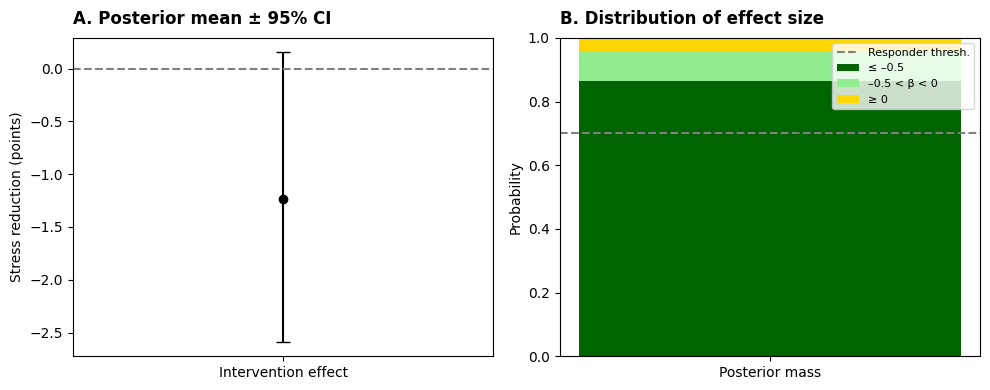

In [52]:
def run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    mad = np.median(np.abs(y - np.median(y)))
    scale = max(mad, 2.0)

    with pm.Model() as model:
        beta0    = pm.StudentT('beta0',    nu=3, mu=0, sigma=scale)
        beta_int = pm.StudentT('beta_int', nu=3, mu=0, sigma=scale)
        if include_fac1:
            beta_f1 = pm.StudentT('beta_f1', nu=3, mu=0, sigma=scale)
        if include_fac2:
            beta_f2 = pm.StudentT('beta_f2', nu=3, mu=0, sigma=scale)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfStudentT('sigma', nu=3, sigma=scale)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Only intervention")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=False)

print("\nModel: Intervention + fac1")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=False)

print("\nModel: Intervention + fac2")
run_ar1_model_data_driven_scale(include_fac1=False, include_fac2=True)

print("\nModel: Intervention + fac1 + fac2")
run_ar1_model_data_driven_scale(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Regression with Consecutive‐Day Adjustment

Only intervention:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 362 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.313  0.518    -2.206     -0.251      0.022    0.013     540.0   
rho       0.040  0.241    -0.425      0.520      0.009    0.009     715.0   
sigma     1.552  0.216     1.167      1.960      0.007    0.007     967.0   

          ess_tail  r_hat  
beta_int     715.0   1.02  
rho          488.0   1.01  
sigma        796.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 93.60%
P(beta_int ≤ –0.5) = 93.60%
P(–0.5 < beta_int < 0) = 6.00%
P(beta_int ≥ 0) = 0.40%


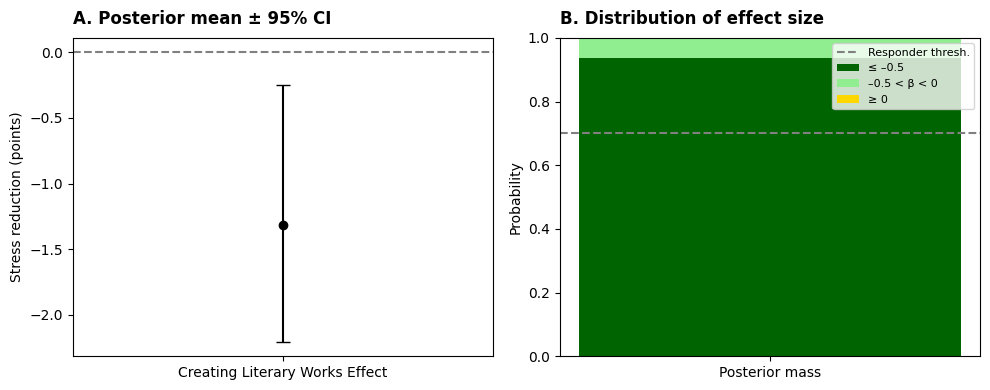


Intervention + fac1:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 659 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.228  0.539    -2.253     -0.170      0.024    0.016     517.0   
rho       0.270  0.287    -0.331      0.781      0.014    0.008     389.0   
sigma     1.433  0.196     1.088      1.823      0.009    0.007     451.0   
beta_f1   0.403  0.145     0.109      0.677      0.007    0.005     382.0   

          ess_tail  r_hat  
beta_int     671.0   1.01  
rho          415.0   1.00  
sigma        547.0   1.01  
beta_f1      442.0   1.02  
P(intervention reduces stress by ≥ 0.5 points) = 90.20%
P(beta_int ≤ –0.5) = 90.20%
P(–0.5 < beta_int < 0) = 8.30%
P(beta_int ≥ 0) = 1.50%


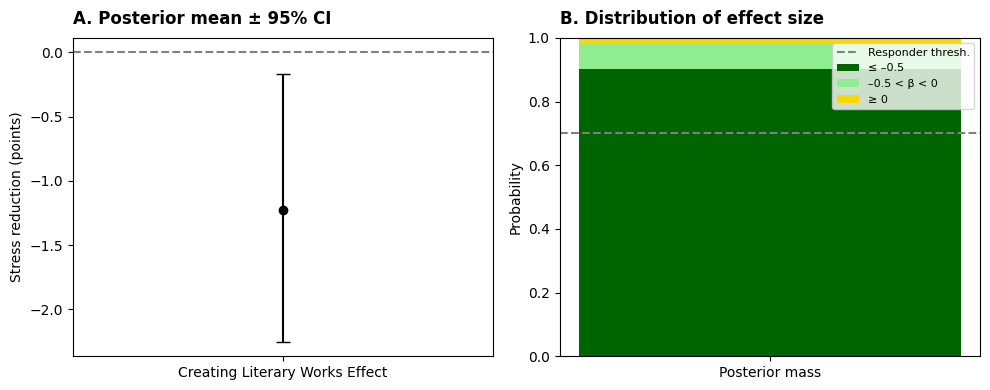


Intervention + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 705 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.182  0.567    -2.285     -0.109      0.023    0.021     615.0   
rho       0.022  0.254    -0.442      0.567      0.009    0.009     799.0   
sigma     1.577  0.228     1.166      2.008      0.009    0.007     679.0   
beta_f2   0.239  0.209    -0.132      0.685      0.010    0.007     408.0   

          ess_tail  r_hat  
beta_int     519.0    1.0  
rho          609.0    1.0  
sigma        650.0    1.0  
beta_f2      552.0    1.0  
P(intervention reduces stress by ≥ 0.5 points) = 88.90%
P(beta_int ≤ –0.5) = 88.90%
P(–0.5 < beta_int < 0) = 8.40%
P(beta_int ≥ 0) = 2.70%


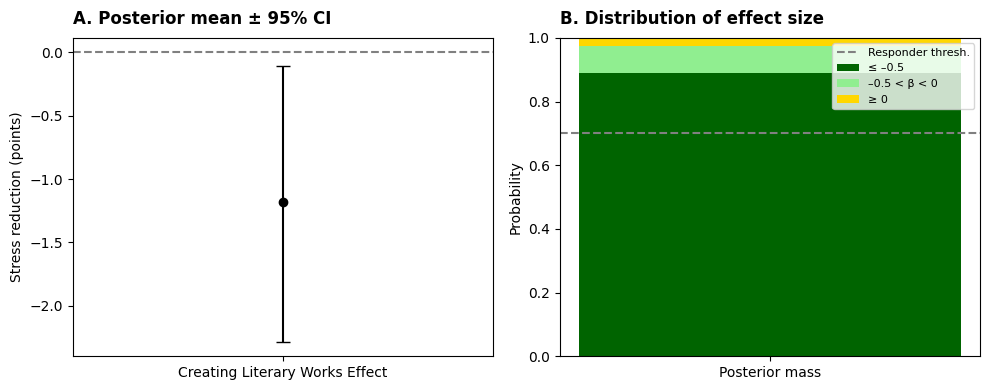


Intervention + fac1 + fac2:


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\pymc\model\core.py:1300: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_obs_unobserved]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 876 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.215  0.563    -2.301     -0.091      0.026    0.016     473.0   
rho       0.237  0.281    -0.254      0.851      0.015    0.010     356.0   
sigma     1.436  0.193     1.116      1.838      0.008    0.008     594.0   
beta_f1   0.378  0.153     0.086      0.659      0.008    0.005     347.0   
beta_f2   0.126  0.191    -0.225      0.502      0.010    0.007     390.0   

          ess_tail  r_hat  
beta_int     746.0   1.01  
rho          339.0   1.01  
sigma        512.0   1.00  
beta_f1      545.0   1.01  
beta_f2      405.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 89.70%
P(beta_int ≤ –0.5) = 89.70%
P(–0.5 < beta_int < 0) = 8.80%
P(beta_int ≥ 0) = 1.50%


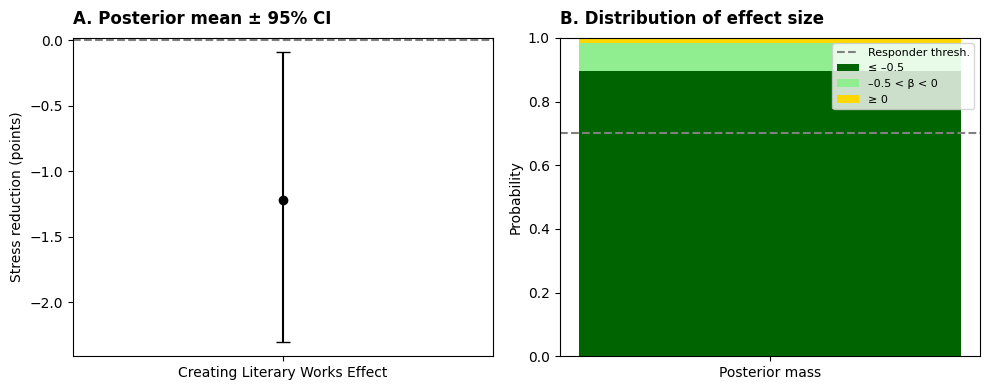

(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
 beta_int -1.215  0.563    -2.301     -0.091      0.026    0.016     473.0   
 rho       0.237  0.281    -0.254      0.851      0.015    0.010     356.0   
 sigma     1.436  0.193     1.116      1.838      0.008    0.008     594.0   
 beta_f1   0.378  0.153     0.086      0.659      0.008    0.005     347.0   
 beta_f2   0.126  0.191    -0.225      0.502      0.010    0.007     390.0   
 
           ess_tail  r_hat  
 beta_int     746.0   1.01  
 rho          339.0   1.01  
 sigma        512.0   1.00  
 beta_f1      545.0   1.01  
 beta_f2      405.0   1.01  )

In [53]:
def run_ar1_model(df_mea, use_fac1=False, use_fac2=False):
    days_full = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})

    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome'][
        ['current_day_of_study',
         'survey1_question1_response',   
         'current_intervention_name']
    ]
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators'][
        ['current_day_of_study',
         'survey2_question1_response',   
         'survey2_question2_response']   
    ]

    data = (
        days_full
        .merge(outcome_data,  on='current_day_of_study', how='left')
        .merge(mediator_data, on='current_day_of_study', how='left')
        .sort_values('current_day_of_study')
        .reset_index(drop=True)
    )

    days   = data['current_day_of_study'].values
    y      = data['survey1_question1_response'].values.astype(float)  
    n      = len(y)  

    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(float).fillna(0).values

    if use_fac1:
        fac1 = data['survey2_question1_response'].values.astype(float)
        fac1 = np.nan_to_num(fac1, nan=0.0)
    else:
        fac1 = np.zeros_like(days, dtype=float)

    if use_fac2:
        fac2 = data['survey2_question2_response'].values.astype(float)
        fac2 = np.nan_to_num(fac2, nan=0.0)
    else:
        fac2 = np.zeros_like(days, dtype=float)

    obs_mask = ~np.isnan(y)
    consec   = np.zeros(n, dtype=float)
    consec[1:] = (obs_mask[1:] & obs_mask[:-1]).astype(float)

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if use_fac1:
            beta_f1  = pm.Normal('beta_f1',  mu=0, sigma=10)
        if use_fac2:
            beta_f2  = pm.Normal('beta_f2',  mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if use_fac1:
            mu = mu + beta_f1 * fac1
        if use_fac2:
            mu = mu + beta_f2 * fac2

        y_tt      = pt.constant(y)            
        mu_tt     = mu
        consec_tt = pt.constant(consec)

        def ar1_step(y_prev, mu_prev, mu_curr, consec_prev, rho):
            ar_term = pt.switch(pt.eq(consec_prev, 1.0), rho * (y_prev - mu_prev), 0.0)
            return mu_curr + ar_term

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu_tt[:-1], mu_tt[1:], consec_tt[:-1]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu_tt[0]], y_pred_scan], axis=0)

        y_obs_masked = np.ma.masked_invalid(y)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_obs_masked)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if use_fac1:
        var_names.append('beta_f1')
    if use_fac2:
        var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4),
                             gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Creating Literary Works Effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left',
                 pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold',       label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left',
                 pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

    return trace, summary

print("Only intervention:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=False)

print("\nIntervention + fac1:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=False)

print("\nIntervention + fac2:")
run_ar1_model(df_mea, use_fac1=False, use_fac2=True)

print("\nIntervention + fac1 + fac2:")
run_ar1_model(df_mea, use_fac1=True, use_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators - Mean Imputation Method

In [54]:
imputed_data_o = df_mea[df_mea['measurement_name'] == 'Outcome'].copy()
imputed_data_o['current_day_of_study'] = imputed_data_o['current_day_of_study'].astype(int)

imputed_data_m = df_mea[df_mea['measurement_name'] == 'Mediators'].copy()
imputed_data_m['current_day_of_study'] = imputed_data_m['current_day_of_study'].astype(int)

days = pd.DataFrame({'current_day_of_study': range(0, 32)})

imputed_complete_o = days.merge(
    imputed_data_o, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)

imputed_complete_m = days.merge(
    imputed_data_m, 
    how='left', 
    on='current_day_of_study'
)

imputed_complete_m['measurement_name'].fillna('Mediators', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_17300\1570007407.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputed_complete_o['measurement_name'].fillna('Outcome', inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_17300\1570007407.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [55]:
df_o = imputed_complete_o.copy()
df_m = imputed_complete_m.copy()
pattern = (
    ['A'] * 4 +
    ['B'] * 8 +
    ['A'] * 4 +
    ['B'] * 4 +
    ['A'] * 8 +
    ['B'] * 4
)
txt = {
    'A': "Creating Literary Works!",
    'B': "Not Creating Literary Works!"
}

df_unique_o = (
    df_o
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_o = (
    df_unique_o
    .reindex(range(0, 32))                     
    .reset_index()                             
)

mask_o = df_fill_o['current_intervention_name'].isna()
df_fill_o.loc[mask_o, 'current_intervention_name'] = (
    df_fill_o.loc[mask_o, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

df_unique_m = (
    df_m
    .sort_values('current_day_of_study')       
    .groupby('current_day_of_study', as_index=True)
    .first()                                   
)

df_fill_m = (
    df_unique_m
    .reindex(range(0, 32))                     
    .reset_index()                            
)

mask_m = df_fill_m['current_intervention_name'].isna()
df_fill_m.loc[mask_m, 'current_intervention_name'] = (
    df_fill_m.loc[mask_m, 'current_day_of_study']
            .map(lambda day: txt[ pattern[int(day)] ])
)

In [56]:
df_mean_imp_o = df_fill_o.copy()
df_mean_imp_m = df_fill_m.copy()
df_mean_imp_o['survey1_question1_response'] = (
    df_mean_imp_o
    .groupby('current_intervention_name')['survey1_question1_response']
    .transform(lambda grp: grp.fillna(grp.mean()))
)

cols_to_impute = [
    'survey2_question1_response',
    'survey2_question2_response'
]

for col in cols_to_impute:
    df_mean_imp_m[col] = (
        df_mean_imp_m
        .groupby('current_intervention_name')[col]
        .transform(lambda grp: grp.fillna(grp.mean()))
    )

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 190 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.409  0.477    -2.333     -0.488      0.021    0.015     506.0   
rho       0.082  0.189    -0.279      0.423      0.008    0.006     579.0   
sigma     1.467  0.191     1.118      1.859      0.007    0.007     729.0   

          ess_tail  r_hat  
beta_int     608.0   1.01  
rho          597.0   1.00  
sigma        650.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 96.70%
P(beta_int ≤ –0.5) = 96.70%
P(–0.5 < beta_int < 0) = 2.90%
P(beta_int ≥ 0) = 0.40%


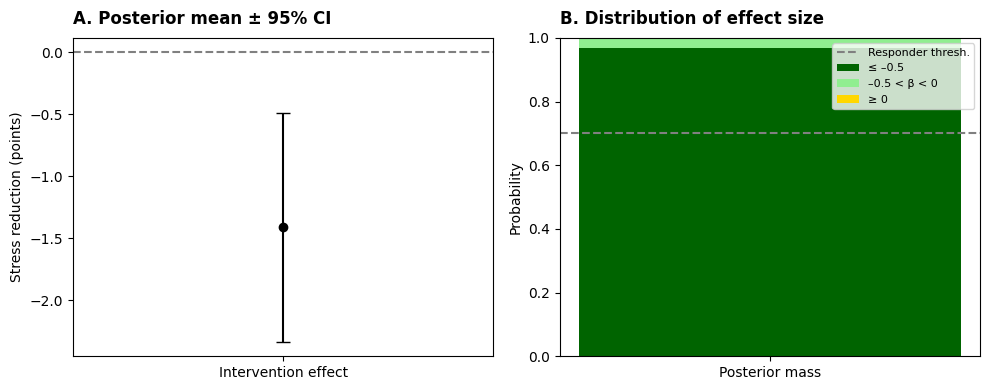

Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 272 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.331  0.502    -2.271     -0.297      0.021    0.019     562.0   
rho       0.191  0.215    -0.230      0.593      0.011    0.010     391.0   
sigma     1.316  0.173     0.993      1.650      0.006    0.007     951.0   
beta_f1   0.388  0.138     0.094      0.644      0.006    0.005     513.0   

          ess_tail  r_hat  
beta_int     449.0   1.00  
rho          340.0   1.00  
sigma        642.0   1.01  
beta_f1      531.0   1.00  
P(intervention reduces stress by ≥ 0.5 points) = 94.50%
P(beta_int ≤ –0.5) = 94.50%
P(–0.5 < beta_int < 0) = 4.70%
P(beta_int ≥ 0) = 0.80%


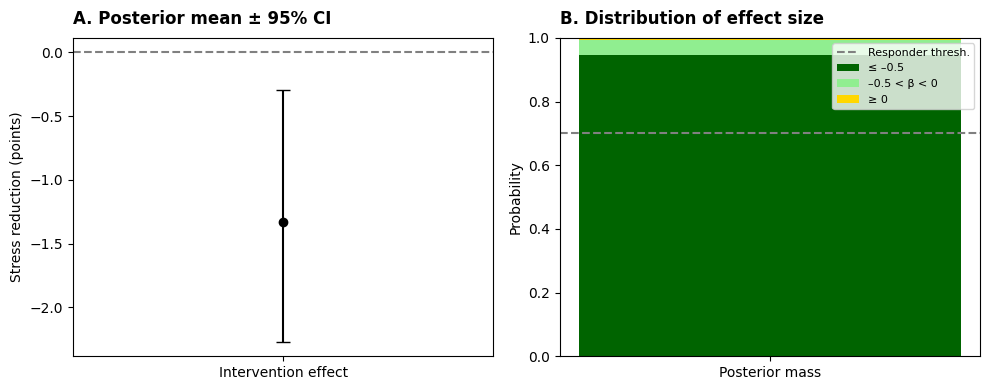

Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 251 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.211  0.510    -2.200     -0.247      0.021    0.016     614.0   
rho       0.088  0.200    -0.278      0.497      0.008    0.008     638.0   
sigma     1.459  0.191     1.148      1.876      0.007    0.008     732.0   
beta_f2   0.230  0.194    -0.134      0.618      0.009    0.006     428.0   

          ess_tail  r_hat  
beta_int     713.0   1.00  
rho          433.0   1.00  
sigma        627.0   1.00  
beta_f2      700.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 90.70%
P(beta_int ≤ –0.5) = 90.70%
P(–0.5 < beta_int < 0) = 8.20%
P(beta_int ≥ 0) = 1.10%


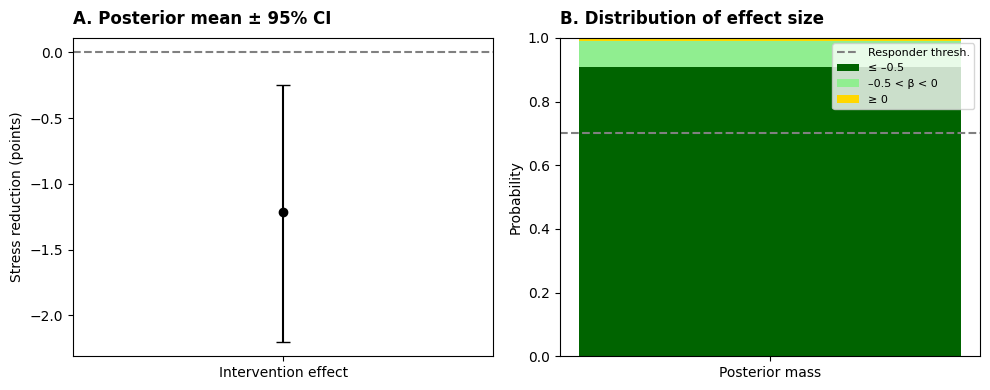

Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 259 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.271  0.520    -2.202     -0.204      0.019    0.020     732.0   
rho       0.198  0.190    -0.150      0.564      0.007    0.005     721.0   
sigma     1.337  0.183     0.984      1.674      0.007    0.006     662.0   
beta_f1   0.368  0.135     0.101      0.624      0.005    0.004     728.0   
beta_f2   0.138  0.179    -0.194      0.519      0.008    0.007     498.0   

          ess_tail  r_hat  
beta_int     580.0   1.00  
rho          600.0   1.00  
sigma        597.0   1.00  
beta_f1      680.0   1.00  
beta_f2      460.0   1.01  
P(intervention reduces stress by ≥ 0.5 points) = 93.00%
P(beta_int ≤ –0.5) = 93.00%
P(–0.5 < beta_int < 0) = 5.80%
P(beta_int ≥ 0) = 1.20%


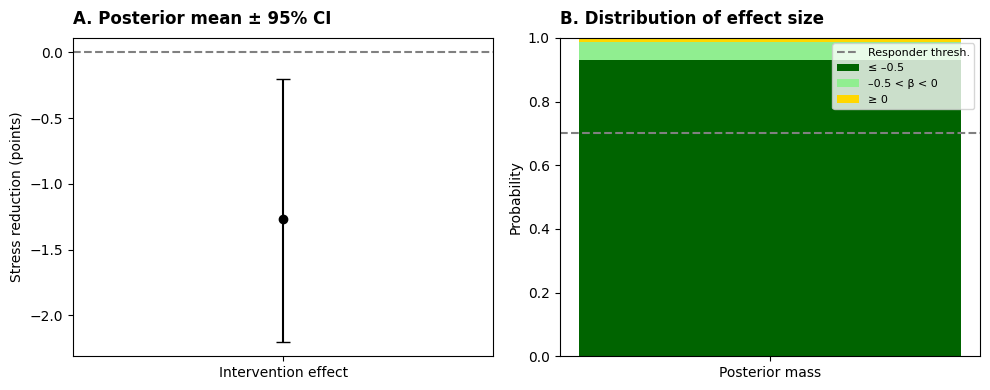

In [57]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mean_imp_o.copy()
    mediator_data = df_mean_imp_m.copy()

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    data = pd.merge(
        outcome_data[merge_cols],
        mediator_data[['current_day_of_study'] + mediator_cols] if mediator_cols else outcome_data[['current_day_of_study']],
        on='current_day_of_study',
        how='inner'
    ).dropna().sort_values('current_day_of_study').reset_index(drop=True)

    y = data['survey1_question1_response'].values
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(int).values
    n = len(y)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho      = pm.Uniform('rho',     lower=-1, upper=1)
        sigma    = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * fac1
        if include_fac2:
            mu = mu + beta_f2 * fac2

        y_tt = pt.constant(y)

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_tt[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1,
            name="ar1_scan"
        )

        y_pred = pt.concatenate([[mu[0]], y_pred_scan], axis=0)
        pm.Normal('y_obs', mu=y_pred, sigma=sigma, observed=y_tt)

        trace = pm.sample(
            draws=500,
            tune=500,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True
        )

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1:
        var_names.append('beta_f1')
    if include_fac2:
        var_names.append('beta_f2')
    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    prob_responder = (trace.posterior['beta_int'] < -0.5).mean().item()
    print(f"P(intervention reduces stress by ≥ 0.5 points) = {prob_responder:.2%}")

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

    mean_beta = summary.loc['beta_int', 'mean']
    hdi_low   = summary.loc['beta_int', 'hdi_2.5%']
    hdi_high  = summary.loc['beta_int', 'hdi_97.5%']

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 1]})

    ax = axes[0]
    ax.errorbar(0, mean_beta,
                yerr=[[mean_beta - hdi_low], [hdi_high - mean_beta]],
                fmt='o', capsize=5, color='black')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_xticks([0])
    ax.set_xticklabels(["Intervention effect"])
    ax.set_ylabel('Stress reduction (points)')
    ax.set_title('A. Posterior mean ± 95% CI', loc='left', pad=10, fontsize=12, fontweight='bold')

    ax = axes[1]
    ax.bar(0, p_le_neg05,    width=0.6, color='darkgreen',  label='≤ –0.5')
    ax.bar(0, p_between,     width=0.6, bottom=p_le_neg05, color='lightgreen', label='–0.5 < β < 0')
    ax.bar(0, p_ge0,         width=0.6, bottom=p_le_neg05+p_between, color='gold', label='≥ 0')
    ax.axhline(0.7, color='gray', linestyle='--', label='Responder thresh.')
    ax.set_xticks([0])
    ax.set_xticklabels(['Posterior mass'])
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('B. Distribution of effect size', loc='left', pad=10, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=8)

    plt.tight_layout()
    plt.show()

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

#### Bayesian AR(1) Model of Daily Stress Response to Creating Literary Works and Mediators - Latent Variable Method

In [58]:
def run_ar1_model(include_fac1=False, include_fac2=False):
    outcome_data = df_mea[df_mea['measurement_name'] == 'Outcome']
    mediator_data = df_mea[df_mea['measurement_name'] == 'Mediators']

    merge_cols = ['current_day_of_study', 'survey1_question1_response', 'current_intervention_name']
    mediator_cols = []
    if include_fac1:
        mediator_cols.append('survey2_question1_response')
    if include_fac2:
        mediator_cols.append('survey2_question2_response')

    all_days = pd.DataFrame({'current_day_of_study': np.arange(0, 32)})
    outcome_data = pd.merge(all_days, outcome_data[merge_cols], on='current_day_of_study', how='left')
    if mediator_cols:
        mediator_data = pd.merge(all_days,
                                  mediator_data[['current_day_of_study'] + mediator_cols],
                                  on='current_day_of_study', how='left')
    else:
        mediator_data = all_days.copy()

    data = (pd.merge(outcome_data, mediator_data, on='current_day_of_study', how='left')
              .sort_values('current_day_of_study')
              .reset_index(drop=True))

    y_obs_raw = data['survey1_question1_response'].values
    y_obs = y_obs_raw.astype(float)
    interv = (data['current_intervention_name'] == "Creating Literary Works!").astype(float).fillna(0.0)
    fac1 = data['survey2_question1_response'].values if include_fac1 else None
    fac2 = data['survey2_question2_response'].values if include_fac2 else None
    n = len(y_obs)

    nan_idx = np.isnan(y_obs)
    obs_idx = ~nan_idx
    missing_idx = np.where(nan_idx)[0].tolist()

    with pm.Model() as model:
        beta0    = pm.Normal('beta0',    mu=0, sigma=10)
        beta_int = pm.Normal('beta_int', mu=0, sigma=1)
        if include_fac1:
            beta_f1 = pm.Normal('beta_f1', mu=0, sigma=10)
        if include_fac2:
            beta_f2 = pm.Normal('beta_f2', mu=0, sigma=10)
        rho   = pm.Uniform('rho', lower=-1, upper=1)
        sigma = pm.HalfNormal('sigma', sigma=1)

        mu = beta0 + beta_int * interv
        if include_fac1:
            mu = mu + beta_f1 * pt.as_tensor_variable(np.nan_to_num(fac1, nan=0.0))
        if include_fac2:
            mu = mu + beta_f2 * pt.as_tensor_variable(np.nan_to_num(fac2, nan=0.0))

        y_latent = pm.Normal('y_latent', mu=0, sigma=10, shape=len(missing_idx))

        y_filled = pt.zeros(n)
        y_filled = pt.set_subtensor(y_filled[missing_idx], y_latent)
        y_filled = pt.set_subtensor(y_filled[obs_idx], y_obs[obs_idx])

        def ar1_step(y_prev, mu_prev, mu_curr, rho):
            return mu_curr + rho * (y_prev - mu_prev)

        y_pred_scan, _ = scan(
            fn=ar1_step,
            sequences=[y_filled[:-1], mu[:-1], mu[1:]],
            non_sequences=[rho],
            n_steps=n-1
        )
        y_pred = pt.concatenate([mu[:1], y_pred_scan], axis=0)

        pm.Normal('y_obs',
                  mu=y_pred[obs_idx],
                  sigma=sigma,
                  observed=y_obs[obs_idx])

        trace = pm.sample(draws=500, tune=500, chains=2, target_accept=0.9,
                          return_inferencedata=True)

    var_names = ['beta_int', 'rho', 'sigma']
    if include_fac1: var_names.append('beta_f1')
    if include_fac2: var_names.append('beta_f2')

    summary = az.summary(trace, var_names=var_names, hdi_prob=0.95)
    print(summary)

    beta_samples = trace.posterior['beta_int'].values.flatten()
    p_le_neg05 = (beta_samples <= -0.5).mean()
    p_between  = ((beta_samples > -0.5) & (beta_samples < 0)).mean()
    p_ge0      = (beta_samples >= 0).mean()

    print(f"P(beta_int ≤ –0.5) = {p_le_neg05:.2%}")
    print(f"P(–0.5 < beta_int < 0) = {p_between:.2%}")
    print(f"P(beta_int ≥ 0) = {p_ge0:.2%}")

print("Model: Neither fac1 nor fac2 (intervention only)")
run_ar1_model(include_fac1=False, include_fac2=False)

print("Model: Only fac1")
run_ar1_model(include_fac1=True, include_fac2=False)

print("Model: Only fac2")
run_ar1_model(include_fac1=False, include_fac2=True)

print("Model: Both fac1 and fac2")
run_ar1_model(include_fac1=True, include_fac2=True)

Model: Neither fac1 nor fac2 (intervention only)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 309 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.327  0.544    -2.382     -0.276      0.022    0.019     620.0   
rho       0.071  0.115    -0.165      0.305      0.006    0.004     436.0   
sigma     1.527  0.200     1.151      1.907      0.007    0.005     733.0   

          ess_tail  r_hat  
beta_int     536.0    1.0  
rho          629.0    1.0  
sigma        797.0    1.0  
P(beta_int ≤ –0.5) = 92.40%
P(–0.5 < beta_int < 0) = 6.30%
P(beta_int ≥ 0) = 1.30%
Model: Only fac1


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 379 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.382  0.499    -2.334     -0.430      0.016    0.017     920.0   
rho       0.136  0.127    -0.114      0.400      0.007    0.006     336.0   
sigma     1.349  0.196     1.011      1.752      0.007    0.006     807.0   
beta_f1   0.391  0.134     0.156      0.680      0.005    0.004     706.0   

          ess_tail  r_hat  
beta_int     628.0   1.01  
rho          428.0   1.01  
sigma        377.0   1.00  
beta_f1      644.0   1.00  
P(beta_int ≤ –0.5) = 95.60%
P(–0.5 < beta_int < 0) = 4.30%
P(beta_int ≥ 0) = 0.10%
Model: Only fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 412 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.170  0.548    -2.163     -0.111      0.021    0.016     670.0   
rho       0.057  0.120    -0.178      0.308      0.006    0.006     396.0   
sigma     1.556  0.225     1.205      2.045      0.008    0.007     945.0   
beta_f2   0.233  0.214    -0.145      0.690      0.011    0.009     392.0   

          ess_tail  r_hat  
beta_int     669.0    1.0  
rho          404.0    1.0  
sigma        745.0    1.0  
beta_f2      335.0    1.0  
P(beta_int ≤ –0.5) = 89.00%
P(–0.5 < beta_int < 0) = 9.60%
P(beta_int ≥ 0) = 1.40%
Model: Both fac1 and fac2


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta_int, beta_f1, beta_f2, rho, sigma, y_latent]


c:\Users\USER\AppData\Local\r-miniconda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 490 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
beta_int -1.316  0.524    -2.302     -0.278      0.020    0.017     674.0   
rho       0.124  0.122    -0.107      0.374      0.006    0.006     447.0   
sigma     1.381  0.210     1.037      1.820      0.010    0.008     476.0   
beta_f1   0.381  0.142     0.129      0.663      0.005    0.005     765.0   
beta_f2   0.086  0.188    -0.264      0.453      0.009    0.006     469.0   

          ess_tail  r_hat  
beta_int     664.0   1.00  
rho          480.0   1.01  
sigma        652.0   1.00  
beta_f1      642.0   1.00  
beta_f2      674.0   1.00  
P(beta_int ≤ –0.5) = 93.90%
P(–0.5 < beta_int < 0) = 5.10%
P(beta_int ≥ 0) = 1.00%
